# Kaggle team name: vijf5!

# Members:
1. Jesse Coenraad -> JesseCoenraad
2. Jordan van Sintanneland -> JordanvanSint
3. Casper Priem -> CasperPriem
4. Jassar Hasiba -> UrClades

### Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

### Data inladen

In [29]:
train = pd.read_csv('train.csv', parse_dates=True)
test = pd.read_csv('test.csv')

# 1. Exploratieve Data Analyse

## 1.1 Toon de datatypes en basisstatistieken van iedere kolom

In [30]:
display(train.head())
display(train.info())
display(train.describe())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


None

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### 1.1.1 Valt hier iets op?

- Geen missende waarde
- De 'temp', 'atemp', 'hum' en 'windspeed' zijn al genormaliseerd
- 'date_hour', is geen DateTime data type

### 1.1.2 Beschrijf de kolommen

- date_hour: Je hebt informatie over de periode van 1-1-2011 t/m 30-11-2012, metingen per uur
- holiday: Vakantiedag of geen vakantiedag
- weathersit: Weersituatie:
    1. Helder, licht bewolkt, deels bewolkt
    2. Mistig , mistig en licht bewolkt
    3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte regen en zwaar bewolkt
    4. Zware regen,  hagel,  zware mist, sneeuw
- temp: genormaliseerde temperatuur
- atemp: genormaliseerde gevoelstemperatuur
- hum: genormaliseerde luchtvochtigheid
- windspeed: genormaliseerde windsnelheid
- cnt: het aantal dat per uur is verhuurd

## 1.2 Voeg tijdserie elementen toe en gebruik passende visualistaites om relevante patronen zichtbaar te maken.

'date_hour' kolom omzetten naar DateTime data type

In [31]:
train['date_hour'] = pd.to_datetime(train['date_hour'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   16637 non-null  datetime64[ns]
 1   holiday     16637 non-null  int64         
 2   weathersit  16637 non-null  int64         
 3   temp        16637 non-null  float64       
 4   atemp       16637 non-null  float64       
 5   hum         16637 non-null  float64       
 6   windspeed   16637 non-null  float64       
 7   cnt         16637 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 1.0 MB


Extra features toevoegen in de vorm van meer tijdsserie elementen

In [32]:
train['Hour'] = train['date_hour'].dt.hour
train['Day'] = train['date_hour'].dt.dayofweek
train['DayName'] = train['date_hour'].dt.day_name()
train['Month'] = train['date_hour'].dt.month
train['Week'] = train['date_hour'].dt.isocalendar().week
train

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Hour,Day,DayName,Month,Week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,Saturday,1,52
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,Saturday,1,52
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,Saturday,1,52
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,Saturday,1,52
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,Saturday,1,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,Friday,11,48
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,Friday,11,48
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,Friday,11,48
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,Friday,11,48


Plotten van de target kolom 'cnt' ten opzichte van tijdserie elementen

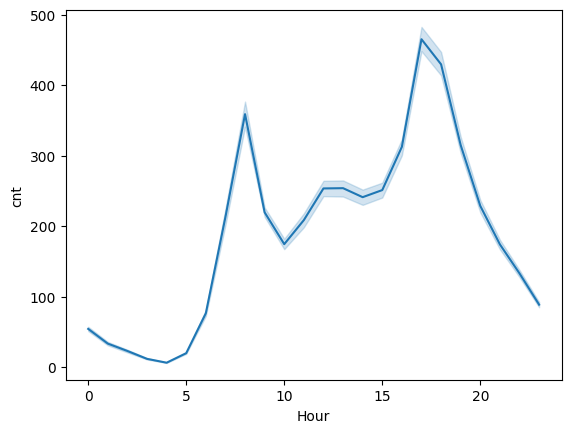

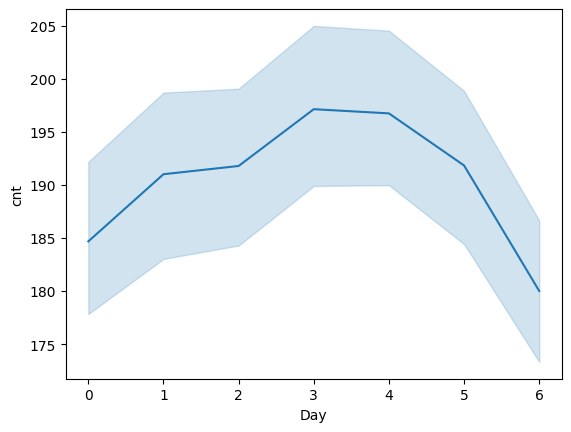

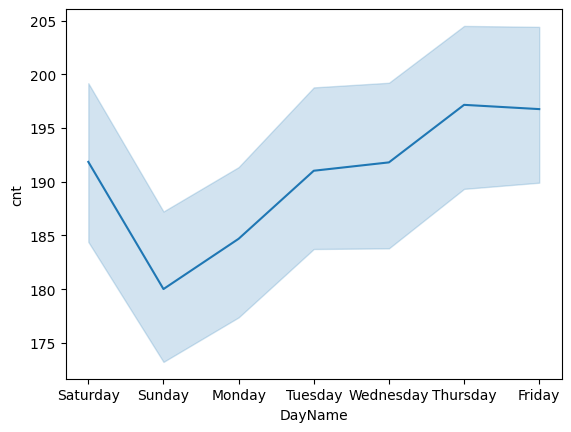

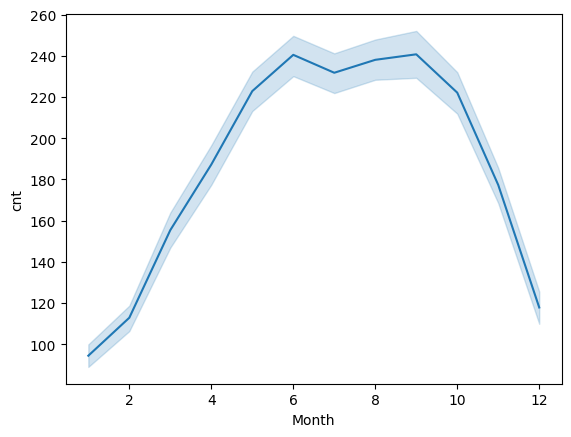

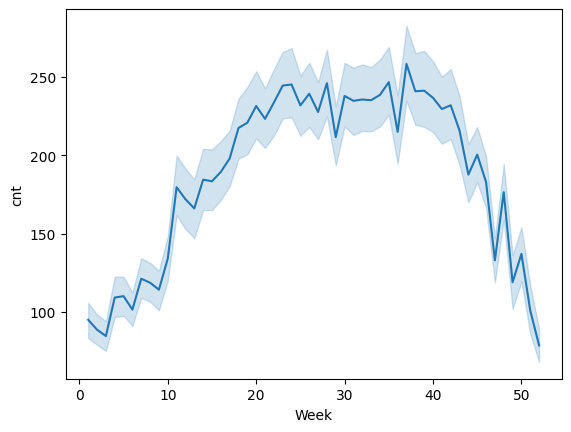

In [33]:
keys = ['Hour', 'Day', 'DayName', 'Month', 'Week']
for key in keys:
    sns.lineplot(data=train, x=key, y='cnt')
    plt.show()

Scatter plots 'cnt' tenopzichte van de numerieke features

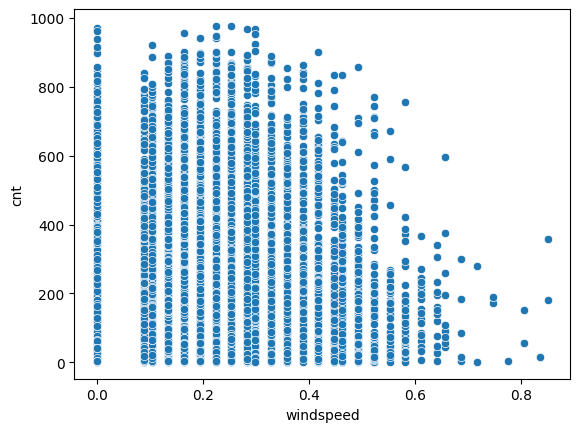

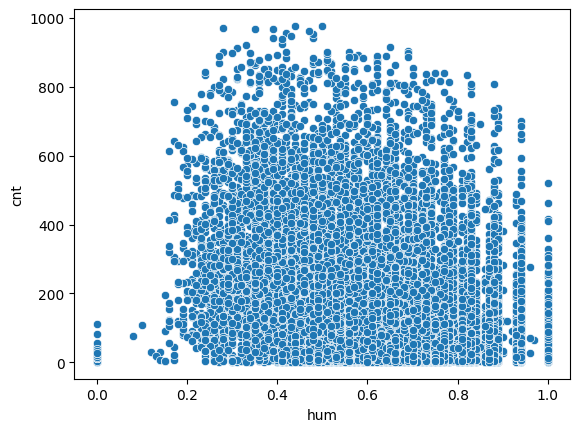

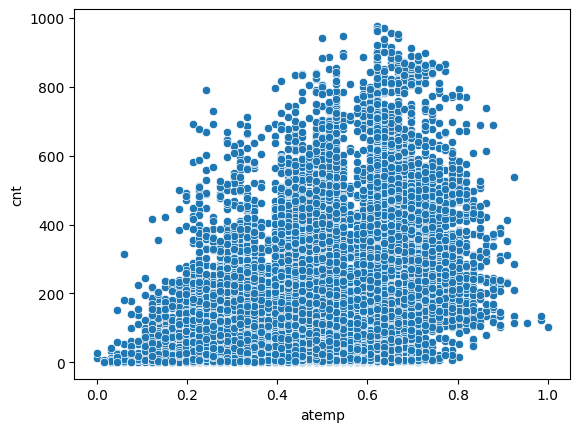

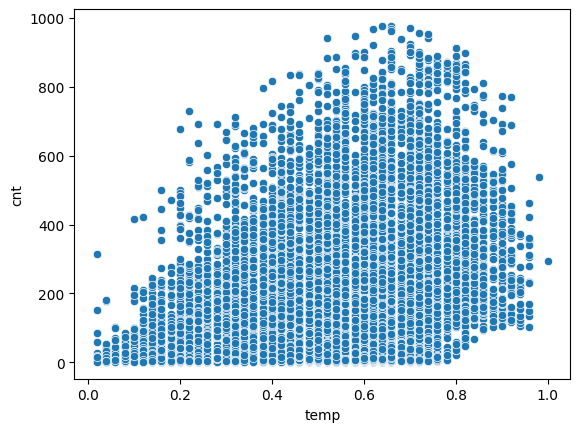

In [34]:
keys = ['windspeed', 'hum', 'atemp', 'temp']

for key in keys:
    sns.scatterplot(data=train, x=key, y='cnt')
    plt.show()

### 1.2.1 Valt hier iets op?


**Lineplots**
- Hour:

    We zien een aantal opvallende patronen in deze visualisaties, we zien grote pieken in het aantal gehuurden producten rond 8 uur sochtends en 6 uur savonds.

- Day/DayName:

    We zien dat op de zondag de verhuur aantallen aanzienlijk lager zijn dan de rest van de dagen.

- Month/Week:

    We zien dat er veel minder vraag is naar het product in het einde en begin van het jaar.


**Scatterplots**
- Windspeed:

    We zien vanaf 0.3 dat er een dalende trend is in het aantal verhuurde producten.

- Hum:

    We zien hier geen duidelijke trend.

- Atemp/Temp:

    We zien dat er bij hogere temperatuur meer wordt verhuurd.

### 1.2.2 Decompose

Lineplot van de date_hour kolom ten opzichten van cnt

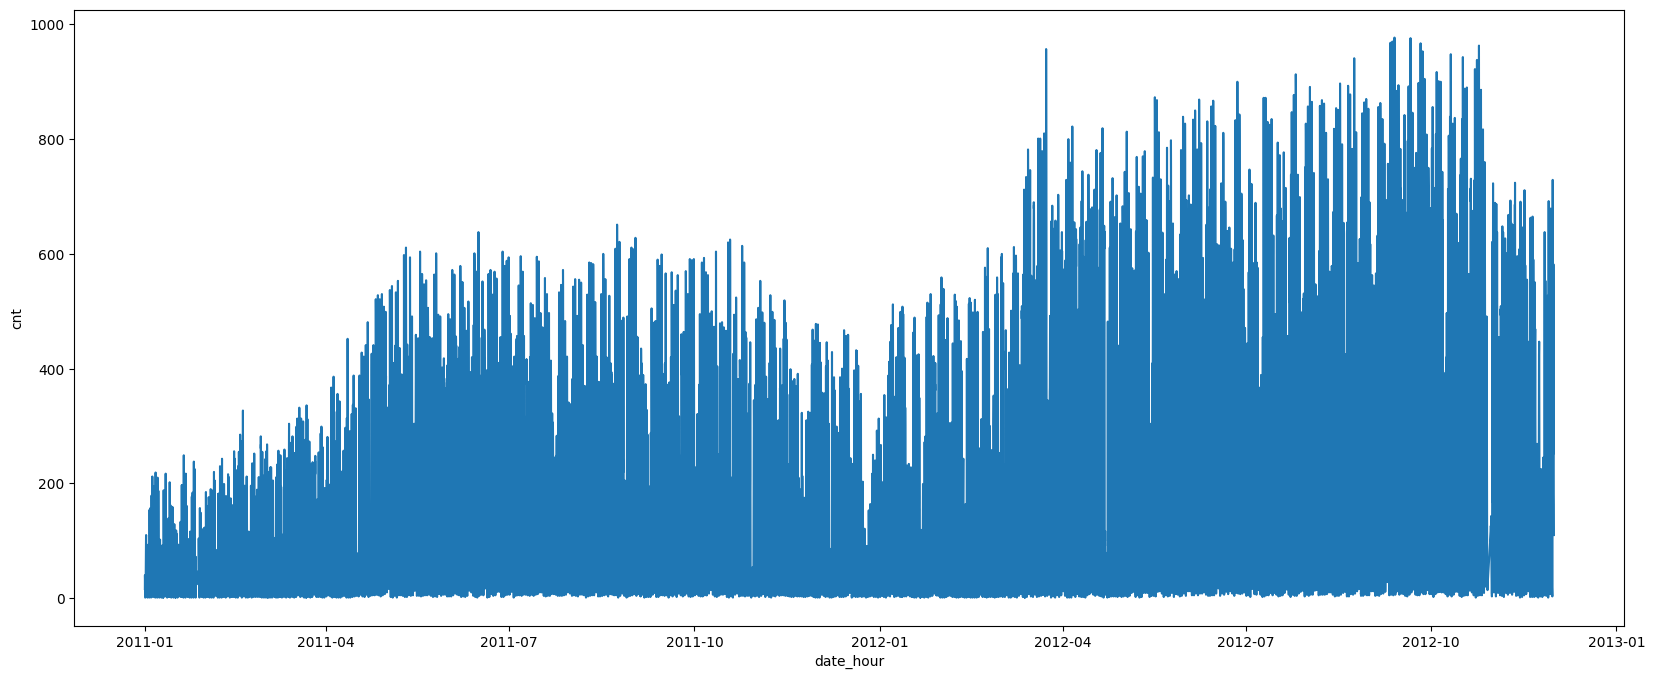

In [35]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=train, x='date_hour', y='cnt')
plt.show()

In [36]:
# 'date_hour' to index
train_decomp = train.set_index('date_hour')
train_decomp = train_decomp['cnt']

In [37]:
# Splitting time to only retain three months of data
split_date = '2011-04-01 00:00:00'
train_decomp_split = train_decomp[:split_date]

In [38]:
# Decomposition of time series
def decompose_ts(series, period=None):


    series_decomp = sm.tsa.seasonal_decompose(series, period=period)
    trend = series_decomp.trend
    seasonal = series_decomp.seasonal
    resid = series_decomp.resid

    return trend, seasonal, resid

trend, seasonal, resid = decompose_ts(train_decomp, period=24)

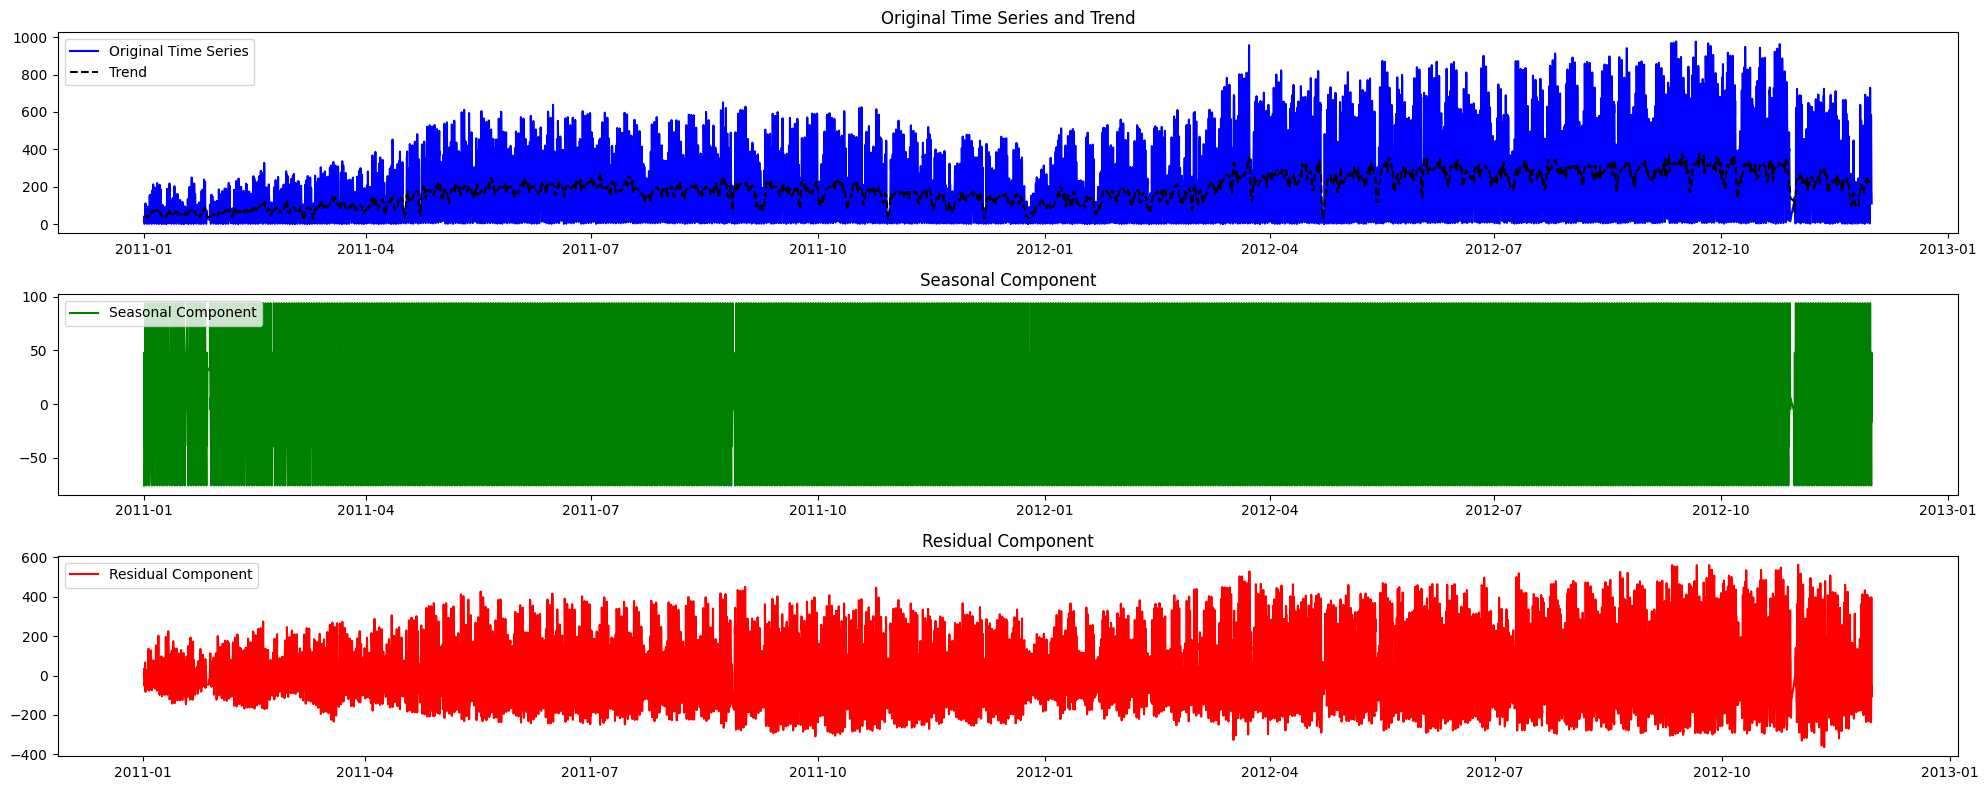

In [ ]:
def plot_ts(series, trend, seasonal, residuals):
    """
    Plots the original time series, trend, seasonal, and residual components.

    Parameters:
        series (pandas.Series): Series with a DateTime index representing the original time series.
        trend (pandas.Series): Time series representing the trend component.
        seasonal (pandas.Series): Time series representing the seasonal component.
        residuals (pandas.Series): Time series representing the residual component.
    """

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 8))

    # Plot the original time series and trend
    axes[0].plot(series.index, series, color='blue', label='Original Time Series')
    axes[0].plot(series.index, trend, color='black', linestyle='dashed', label='Trend')
    axes[0].set_title('Original Time Series and Trend')
    axes[0].legend()

    # Plot the seasonal component
    axes[1].plot(series.index, seasonal, color='green', label='Seasonal Component')
    axes[1].set_title('Seasonal Component')
    axes[1].legend()

    # Plot the residual component
    axes[2].plot(series.index, residuals, color='red', label='Residual Component')
    axes[2].set_title('Residual Component')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

plot_ts(train_decomp, trend, seasonal, resid)


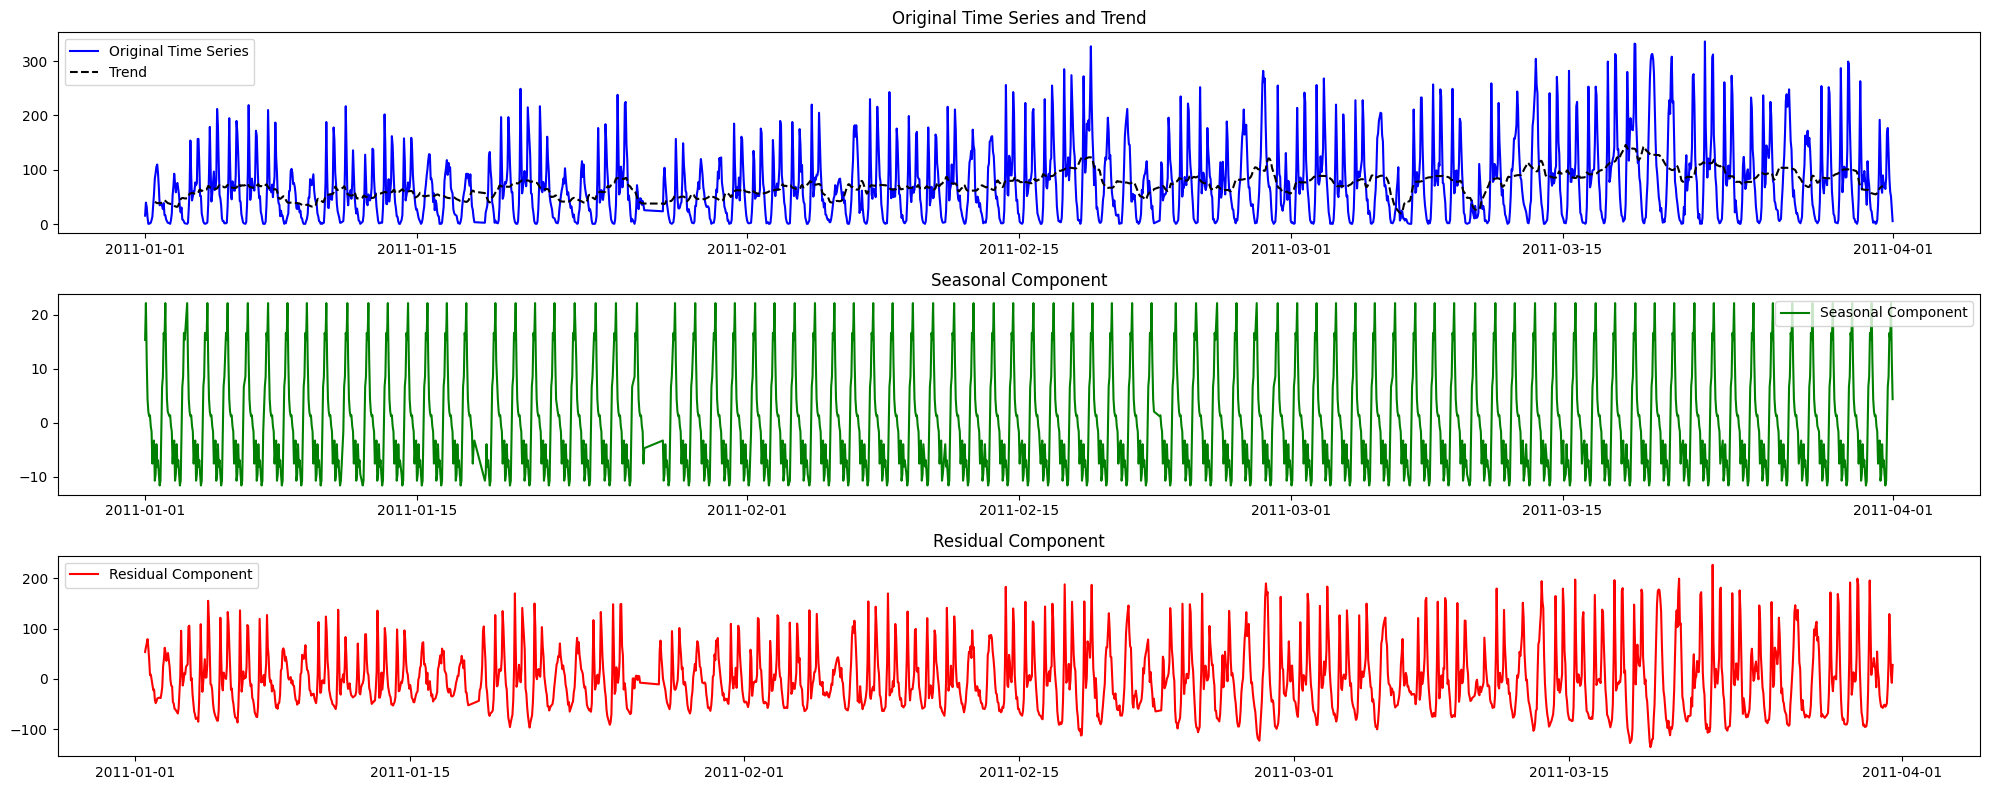

In [40]:
trend2, seasonal2, resid2 = decompose_ts(train_decomp_split, period=24)
plot_ts(train_decomp_split, trend2, seasonal2, resid2)

- Lineplot:

    We zien zowel een stijgende trend als seizoensgebondenheid in de data.

- Decompose:

    We decomposen eerst de gehele tijdserie, hier zien we niet veel op de grafieken doordat er teveel datapunten zijn. Daarom selecteren we maar 3 maanden van de data om dit beter weer te geven.

    - Trend: We zien dat er een stijgende trend is in de trendplot, dit wordt ook duidelijk uit de originele line plot over 2 jaar.
    - Seasonal: We zien dat er duidelijk sprake is van seizoensgebondenheid. (Per dag)
    - Residual: Er is nog veel data dat nog niet verklaard is.

## 1.4* Stationariteit controleren: Stationariteit is een voorwaarde voor veel time series modellen (zoals ARIMA). Controleer op stationariteit met visuele inspectie of met statistische tests zoals de Augmented Dickey-Fuller (ADF) test.

In [ ]:
series = train['cnt']

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(series)

# Print the test results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -6.625164793721735
p-value: 5.9012886686789265e-09
Critical Values:
   1%: -3.430744160906401
   5%: -2.8617142032973706
   10%: -2.5668627239973634


In [ ]:
#Stationary maken

# First-order differencing
series_diff = series.diff().dropna()

# Perform the ADF test on the differenced series
adf_result_diff = adfuller(series_diff)

print("ADF Statistic (Differenced):", adf_result_diff[0])
print("p-value (Differenced):", adf_result_diff[1])


ADF Statistic (Differenced): -29.583404888071367
p-value (Differenced): 0.0


<Axes: ylabel='cnt'>

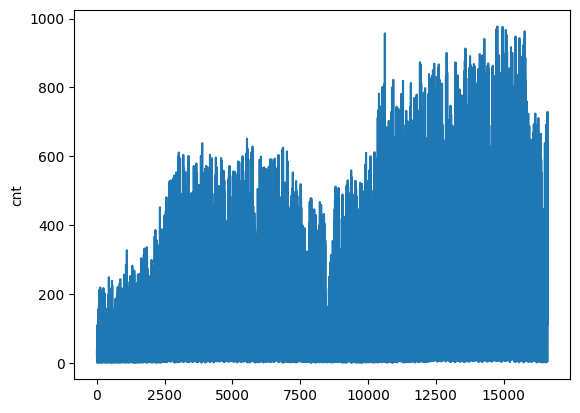

In [54]:
sns.lineplot(data=train['cnt'])

Visueel het verschil zien

<Axes: ylabel='cnt'>

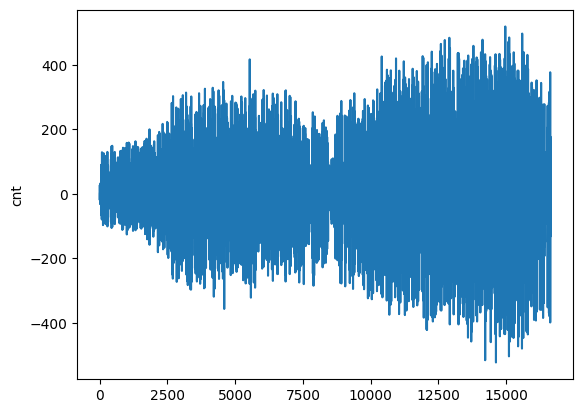

In [44]:
sns.lineplot(data=series_diff)

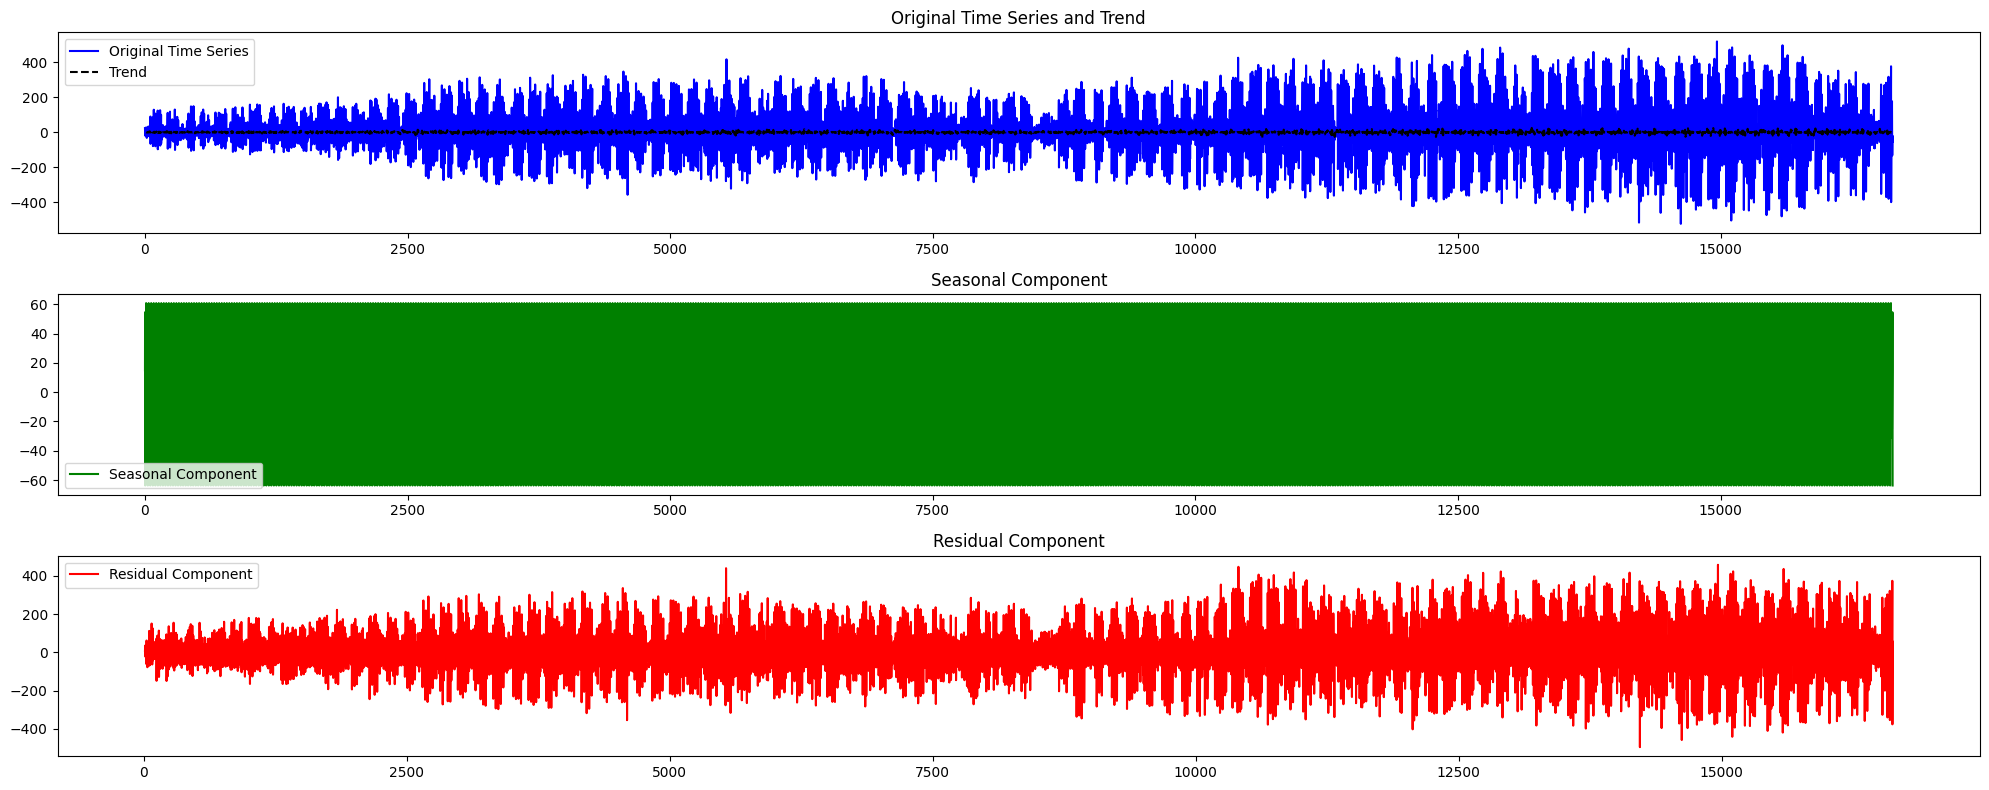

In [45]:
trend3, seasonal3, resid3 = decompose_ts(series_diff, period=24)
plot_ts(series_diff, trend3, seasonal3, resid3)

ACF EN PACF

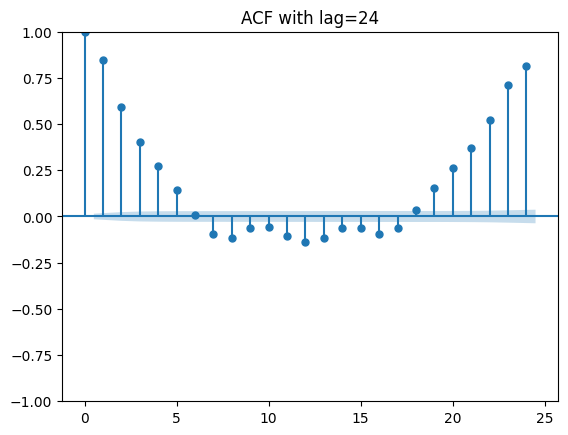

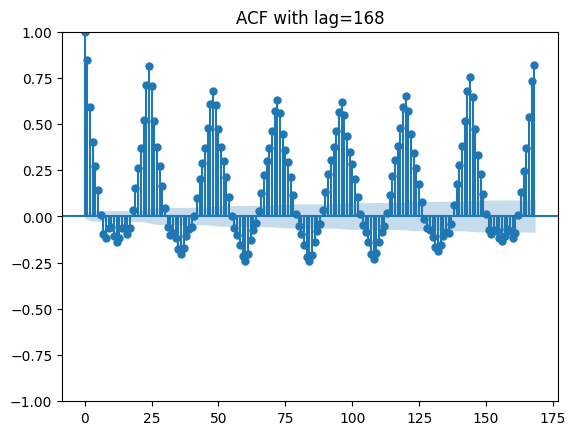

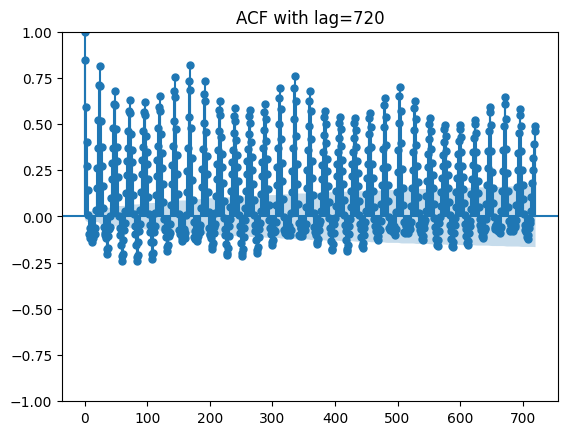

In [46]:
lags = [24, 168, 720]

for lag in lags:
    tsaplots.plot_acf(train_decomp, lags=lag)
    plt.title(f'ACF with lag={lag}')
    plt.show()

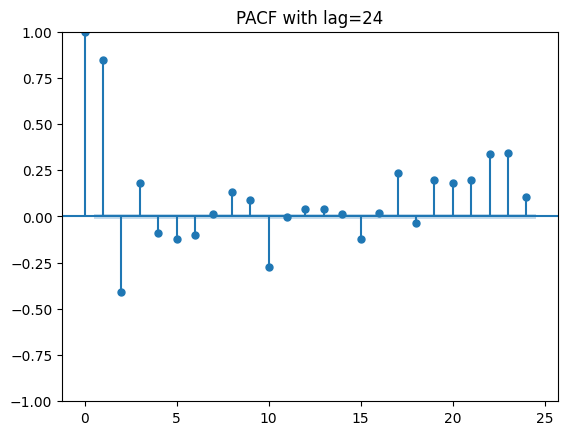

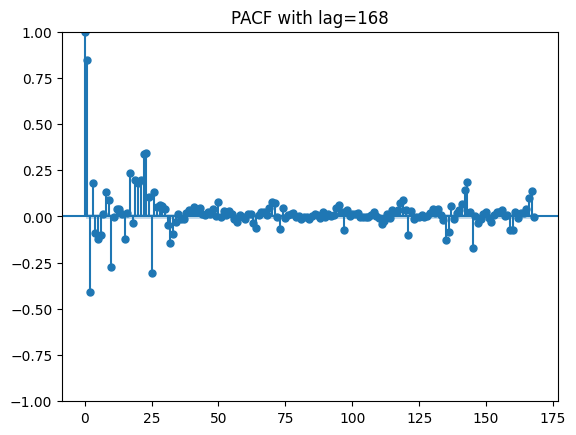

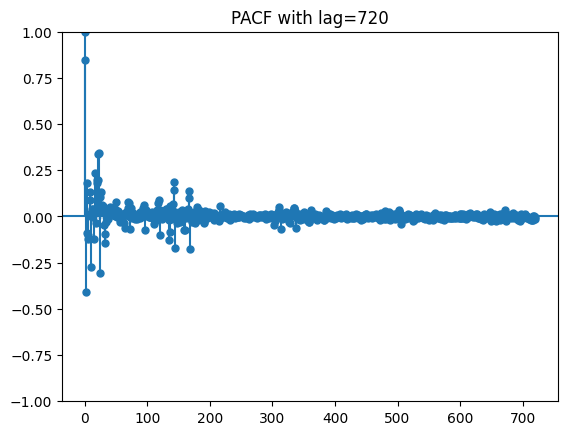

In [47]:
for lag in lags:
    tsaplots.plot_pacf(train_decomp, lags=lag)
    plt.title(f'PACF with lag={lag}')
    plt.show()

kernel density plot

<Axes: xlabel='cnt', ylabel='Density'>

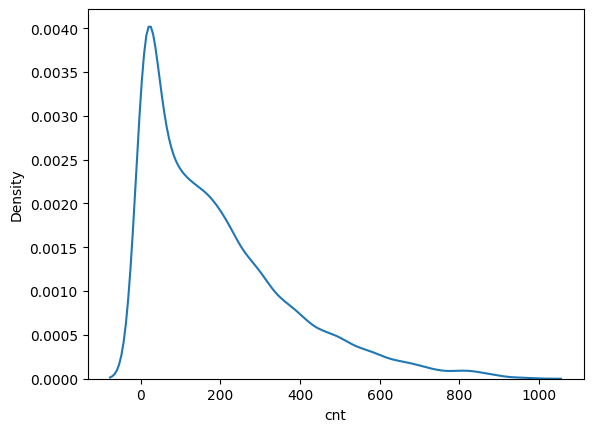

In [48]:
#kernel density plot
sns.kdeplot(train_decomp)

### 1.4.1 Leg uit hoe het werkt en geef je bevindingen

## 1.5 Beschrijf wat de belangrijkste bevindingen zijn van de EDA

# 2. Data-voorbereiding

## 2.1 Verwijder indien nodig niet relevante kolommen

In [49]:
train = train.drop(columns=['DayName', 'Month'])

In [50]:
display(train.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Hour,Day,Week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,0,5,52
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,1,5,52
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2,5,52
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,3,5,52
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,4,5,52


### 2.1.1 Leg uit waarom deze wel of niet verwijderd zijn

- Dayname:

    Wordt verwijderd omdat deze geen int of float is en dezelfde data weergeeft als de 'Day' kolom

- Month:

    Wordt verwijderd omdat dit vrijwel dezelfde data weergeeft als 'Week', maar 'Week' heeft meer datapunten waardoor wij besloten deze te behouden.

## 2.2 Vul eventuele missende waarden in of verwijder ze. Voor time series kan interpolatie een nuttige methode zijn.

In [51]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   16637 non-null  datetime64[ns]
 1   holiday     16637 non-null  int64         
 2   weathersit  16637 non-null  int64         
 3   temp        16637 non-null  float64       
 4   atemp       16637 non-null  float64       
 5   hum         16637 non-null  float64       
 6   windspeed   16637 non-null  float64       
 7   cnt         16637 non-null  int64         
 8   Hour        16637 non-null  int32         
 9   Day         16637 non-null  int32         
 10  Week        16637 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(4), int32(2), int64(3)
memory usage: 1.2 MB


None

### 2.2.1 Leg uit waarom er voor wat gekozen is

Er is geen sprake van missende waardes

## 2.3 Kijk of er outliers zijn

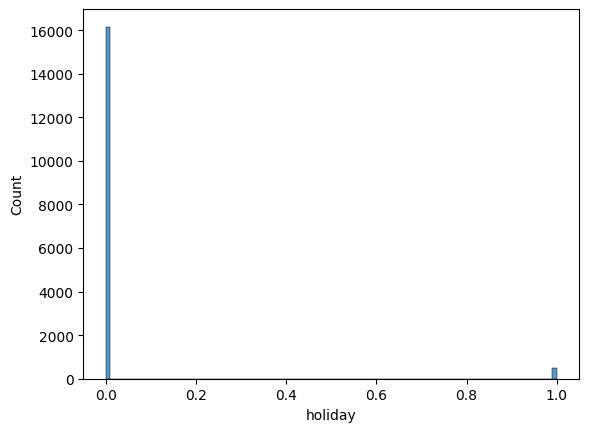

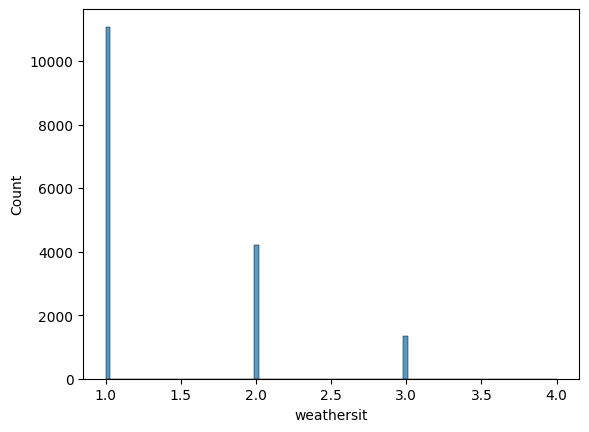

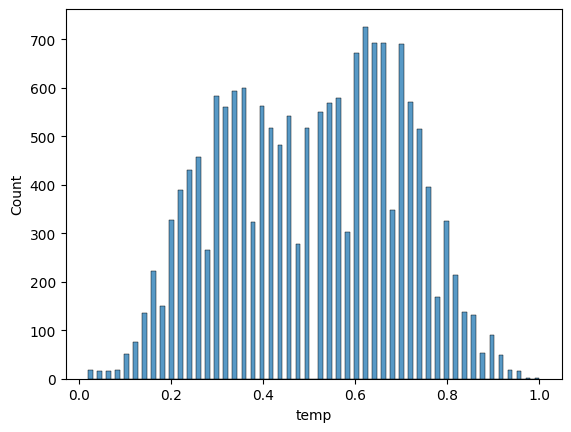

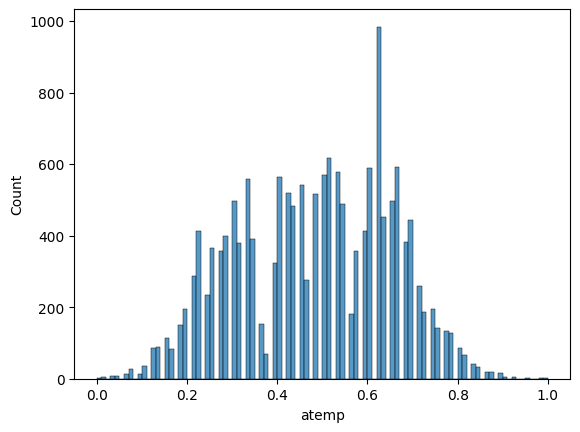

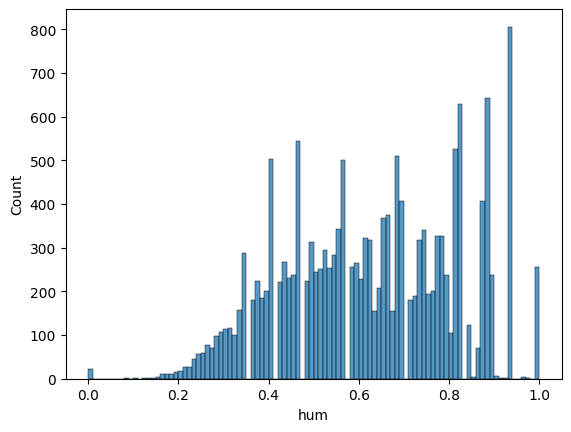

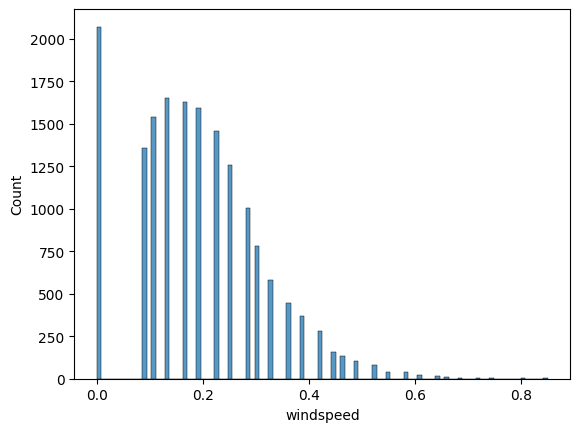

In [52]:
#histplot
keys = ['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

for key in keys:
    sns.histplot(data=train, x=key, bins=100)
    plt.show()


### 2.3.1 Verwijder of corrigeer deze indien nodig

### 2.3.2 Leg uit waarom deze keuze is gemaakt

## 2.4 Schaal/normaliseer de data indien nodig

### 2.4.1 Leg uit waarom voor deze methode is gekozen en voor welke modellen dit uitmaakt

## 2.5 Data sampling indien nodig

### 2.5.1 Leg uit waarom dit wel/niet nodig is en welke methode wordt gebruikt

# 3. Time series feature engineering

Deze opdracht hangt sterk samen met de opdracht 3 (modelleren). Je zult na het toevoegen van features moeten gaan modelleren om te achterhalen wat de invloed van de features is. Daarna zul je waarschijnlijk weer teruggaan naar deze opdracht om nieuwe features uit te proberen. Dit is een iteratief proces. Zorg ervoor dat je uitwerking duidelijk maakt hoe jullie tot de uiteindelijke keuze voor de features en model(len) zijn gekomen

## 3.1 Voeg tijdserie features toe aan de dataset

## 3.2 Onderzoek wat de de invloed is van deze features, samen met de andere features, op de voorspellingen

### 3.2.1 Onderzoek naar seizoenspatronen met Fourier analyse

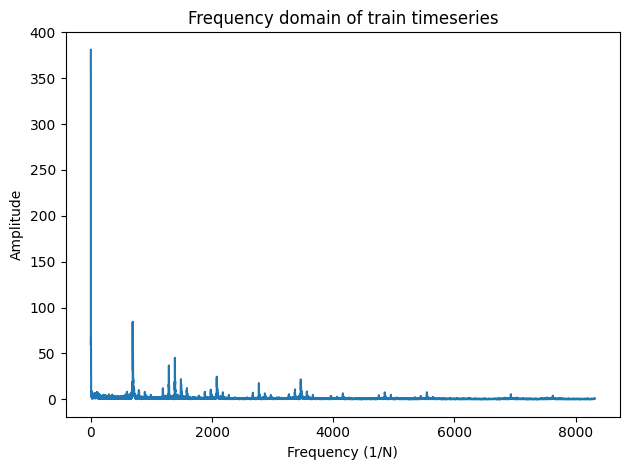

In [60]:
# Calculate the number of samples in the timeseries
N = len(train)

# Compute the Fourier transform of the timeseries
train_ft = np.fft.fft(train['cnt'])

# Compute the magnitude of the frequencies
magnitude = 2.0/N * np.abs(train_ft[:N//2])

# Plot the constituent frequencies
plt.plot(magnitude)
plt.xlabel('Frequency (1/N)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of train timeseries")

#plt.xlim(0, 2000)
plt.tight_layout()
plt.show()

#### 3.2.2 Leg uit hoe het werkt en wat er is gevonden

1460 = 12 uurlijks

730 = dagelijk

104 = weekelijks

2 = jaarlijks


### 3.2.3 Onderzoek naar trends

#### 3.2.4 Leg uit hoe het werkt en wat er is gevonden

### 3.2.5 Onderzoek naar cycli en autocorrelatie

#### 3.2.6 Leg uit hoe het werkt en wat er is gevonden

### 3.2.7 Onderzoek naar andere tijdsgebaseerde features

*denk hier bijvoorbeeld aan:

- lags: Vertragingen in de tijd (bijv. de waarde van vorige dag).
- Rolling statistics: Gemiddelden of varianties over een bepaald venster.
- Datumgerelateerde features: Dag van de week, maand, seizoenen, feestdagen, enz.

#### 3.2.8 Leg uit hoe het werkt en wat er is gevonden

## 3.3 Maak duidelijk hoe jullie tot de uiteindelijke keuze voor de features en model(len) zijn gekomen. Wat is er allemaal geprobeerd?

# 4. Train-test splitsing en validatie

*Cross-validation voor time series: Bij time series data kun je geen willekeurige splitsing gebruiken. Gebruik TimeSeriesSplit uit scikit-learn om met opeenvolgende perioden te valideren, of werk met 'rolling' en 'expanding' vensters.

## 4.1 splits de data

## 4.2 Cross-validation voor time series

### 4.2.1 Leg uit waarom dit anders is voor time series

# 5. Modelleren

# **Hou bij welke hyperparameters je gebruikt voor elke kaggle submission voor 6.3**

## 5.1 Model 1 waar je time series combineert met reguliere feautures (Lineaire regressie)?

### 5.1.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.1.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.1.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.2 Model 2 waar je time series combineert met reguliere feautures (Ensemble)?

### 5.2.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.2.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.2.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.3 Model 3 waar je time series combineert met reguliere feautures?

### 5.3.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.3.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.3.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.4 Model 4 waar je time series combineert met reguliere feautures

### 5.4.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.4.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.4.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.5 Model 5 waar je time series combineert met reguliere feautures

### 5.5.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.5.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.5.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.6 Model 1 van specifieke tijdseriemodellen (SARIMA(X))

### 5.6.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.6.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.6.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.7 Model 2 van specifieke tijdseriemodellen

### 5.7.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.7.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.7.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.8 Model 1 van hybdride modellen

### 5.8.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.8.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.8.3 Pas het model toe op de testset en upload het resultaat op Kaggle

# 6. Bevindingen

## 6.1 Geef een beknopt overzicht van de resultaten

## 6.2 Welke model presteert het beste? Welke parameters gebruikte deze?

## 6.3 Toon je scores op Kaggle en laat zien wat de resultaten waren van verbeteringen op je score op Kaggle

# 7. Conclusie en aanbevelingen

## 7.1 welke features hadden uiteindelijk het meeste invloed op de voorspelling?

## 7.2 Sluit dit aan op de EDA?

## 7.3 Welk advies kun je op basis hiervan geven aan de verhuurder?

## 7.4 Welk model zou je adviseren aan de verhuurder? Waarom? Is dit per definitie het model met de beste voorspellingen of zijn  er ook andere overwegingen? Zo ja, welke?